In [2]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patheffects import Stroke, Normal
import numpy as np
import toml
from datetime import datetime
import pandas as pd
import re
from typing import Union
import os

In [3]:
URL_IMAGE = "./shots/leuven_tiensesteenweg_20231017-114236.png"
image = Path(URL_IMAGE)
assert image.exists()

In [4]:
im = cv2.cvtColor(cv2.imread(image.as_posix()), cv2.COLOR_BGR2RGB)

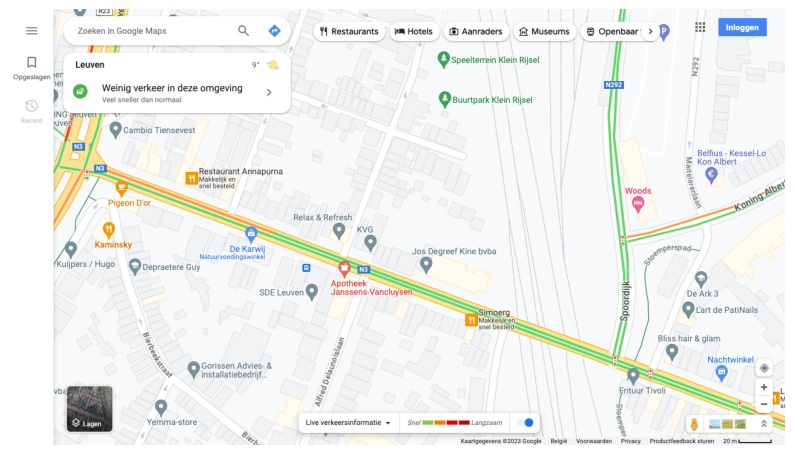

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
plt.imshow(im);

In [6]:
def display_shot(url:  Union[str, os.PathLike]):
    if isinstance(url, str):
        image = Path(url)
    elif isinstance(url, os.PathLike):
        image = url
    else:
        raise TypeError("url must be a string or a path object")
    assert image.exists()
    im = cv2.cvtColor(cv2.imread(image.as_posix()), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_axis_off()
    ax.imshow(im);
    return ax

In [7]:
# Open the TOML file
with open("config.toml", "r") as f:
    # Load the contents of the file into a dictionary
    config = toml.load(f)

# Print the values
print(config)

{'leuven': {'geldenaaksepoort': {'url': 'https://www.google.com/maps/@50.8726718,4.7131464,18z/data=!5m1!1e1'}, 'tiensevest': {'url': 'https://www.google.com/maps/@50.8747536,4.713817,17.97z/data=!5m1!1e1'}, 'tiensesteenweg': {'url': 'https://www.google.com/maps/@50.8733218,4.7172716,18z/data=!5m1!1e1', 'points': [[164, 268], [187, 276], [207, 283], [225, 290], [247, 299], [270, 307], [290, 315], [314, 324], [341, 334], [368, 344], [395, 354], [421, 364], [448, 374], [473, 383], [500, 394], [530, 405], [603, 432], [625, 441], [647, 449], [675, 458], [699, 467], [728, 478], [761, 490], [849, 522], [879, 534], [904, 543], [928, 552], [953, 561], [983, 572], [1028, 589], [1082, 607], [1123, 623], [1163, 638], [1194, 649]]}, 'tiensestraat': {'url': 'https://www.google.com/maps/@50.8748008,4.7106216,17z/data=!5m1!1e1'}}}


In [8]:
streets = list(config["leuven"].keys())
streets

['geldenaaksepoort', 'tiensevest', 'tiensesteenweg', 'tiensestraat']

In [9]:
mosaic = [
    [streets[3], streets[0]],
    [streets[1], streets[2]]
]

In [10]:
plt.rc('axes.spines', top=False, right=False)

In [11]:
URL_IMAGE_DIR = "shots"
url_image_dir = Path(URL_IMAGE_DIR)
assert url_image_dir.exists()
location = "leuven"

In [12]:
point_annots_defaults = {
    'xytext': (10, 10), 'textcoords': 'offset points', 
    # "xycoords": "data",
    'fontsize': 'x-small', 'ha': 'left', 'va': 'bottom', 
    'arrowprops': {
        'arrowstyle': '-', 'connectionstyle': 'angle', 'shrinkB': 0
    }
}

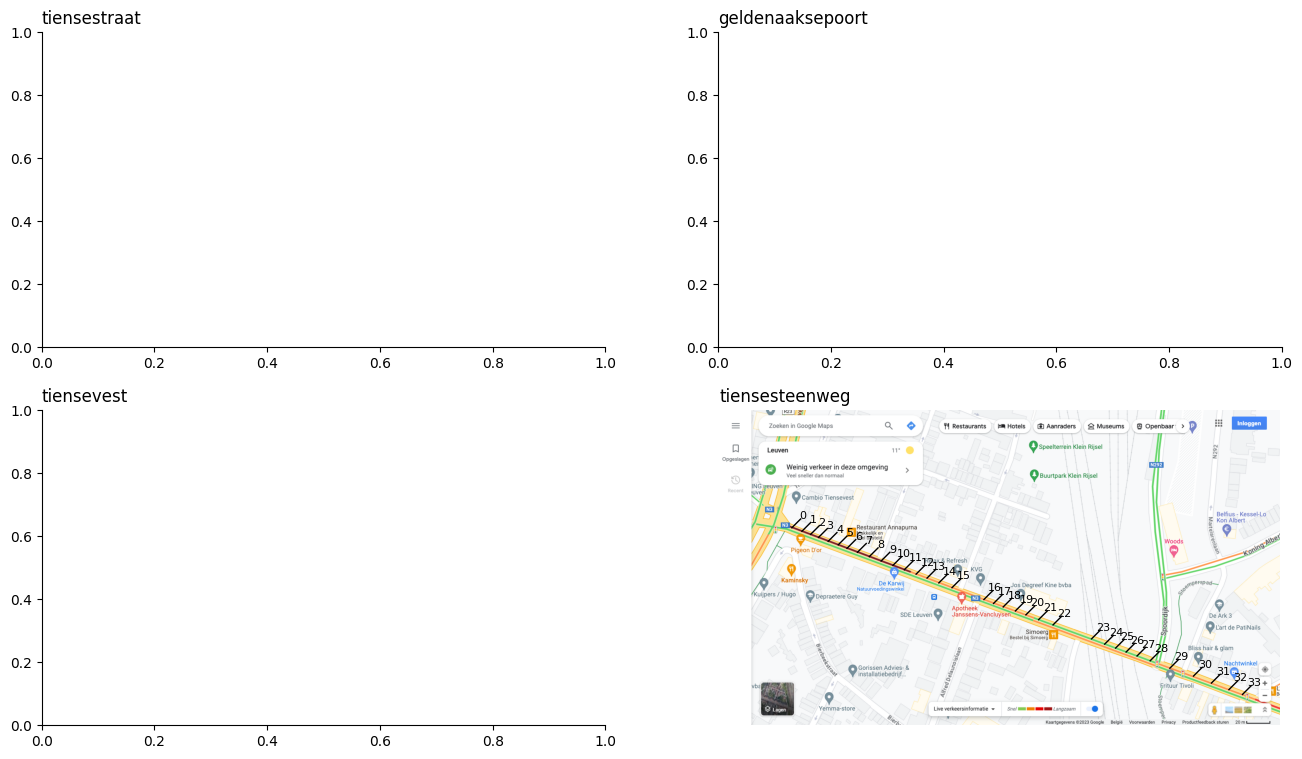

In [18]:
fig, axd = plt.subplot_mosaic(
    mosaic, gridspec_kw={"width_ratios": [1, 1], "wspace": 0.2}, figsize=(16, 9)
)

for title, ax in axd.items():
    ax.set_title(title, size="large", loc="left")

text_offset = 6
line_offset = 20

street_offsets = {"tiensestraat": [-line_offset, line_offset, -text_offset, text_offset, "center", "center"],
                  "tiensevest": [-line_offset, -line_offset, -text_offset, -text_offset, "center", "center"],
                  "geldenaaksepoort": [line_offset, line_offset, text_offset, text_offset, "center", "center"],
                  "tiensesteenweg": [line_offset, -line_offset, text_offset, -text_offset, "center", "center"]}

for street in streets:
    if street != "tiensesteenweg":
        continue
    img_url_path = next(url_image_dir.glob(f"{location}_{street}_*.png"))
    im = cv2.cvtColor(cv2.imread(img_url_path.as_posix()), cv2.COLOR_BGR2RGB)
    axd[street].spines[:].set_visible(False)
    axd[street].yaxis.set_visible(False)
    axd[street].xaxis.set_visible(False)
    axd[street].imshow(im)
    for i, p in enumerate(config[location][street]["points"]):
        x, y = p[0], p[1]
        x_end, y_end = x + street_offsets[street][0], y + street_offsets[street][1]
        axd[street].plot([x, x_end], [y, y_end], color="k", linewidth=1)
        axd[street].annotate(
            f"{i}",
            xy=(x_end, y_end),
            xytext=(x_end + street_offsets[street][2], y_end + street_offsets[street][3]),
            fontsize=8,
            ha=street_offsets[street][4],
            va=street_offsets[street][5],
        )

# display(fig)

In [20]:
max_points = 0
for location in config.keys():
    for street in config[location].keys():
        print (f"{location=} {street=}")
        if not "points" in config[location][street]:
            continue
        number_of_points = len(config[location][street]["points"])
        if number_of_points > max_points:
            max_points = number_of_points
            max_location = location
            max_street = street
print(f"Maximum number of measurement points is {max_points} in {max_street} in {location}")

location='leuven' street='geldenaaksepoort'
location='leuven' street='tiensevest'
location='leuven' street='tiensesteenweg'
location='leuven' street='tiensestraat'
Maximum number of measurement points is 34 in tiensesteenweg in leuven


# Walk over screenshots and sample pixel colors

In [58]:
rows = []
for location in config.keys():
    for street in config[location].keys():
        for p in url_image_dir.glob(f"{location}_{street}_*.png"):
            # print (p.stem)
            timestamp = datetime.strptime(p.stem, f"{location}_{street}_%Y%m%d-%H%M%S")
            if timestamp < datetime(2023, 10, 17, 15, 55, 0):
                # print(f"Skipped {p.stem}")
                continue
            print(timestamp)
            screenshot = cv2.cvtColor(cv2.imread(p.as_posix()), cv2.COLOR_BGR2RGB)
            colors = ()
            if not "points"in config[location][street]:
                continue
            for point in config[location][street]["points"]:
                color = screenshot[point[1], point[0]]
                print(color)
                colors += (color, color[0], color[1], color[2])
            row = (location, street, p, timestamp) + colors
            rows.append(row)

2023-10-17 17:41:19
2023-10-17 18:07:16
2023-10-17 16:13:04
2023-10-17 15:57:28
2023-10-17 17:25:46
2023-10-17 16:59:46
2023-10-17 16:28:39
2023-10-17 17:20:34
2023-10-17 16:07:52
2023-10-17 18:02:05
2023-10-17 17:10:10
2023-10-17 16:23:27
2023-10-17 16:02:40
2023-10-17 17:46:31
2023-10-17 17:36:08
2023-10-17 16:44:13
2023-10-17 17:56:54
2023-10-17 17:04:58
2023-10-17 16:18:16
2023-10-17 16:33:50
2023-10-17 16:39:01
2023-10-17 17:51:42
2023-10-17 17:30:57
2023-10-17 17:15:22
2023-10-17 16:54:35
2023-10-17 16:49:24
2023-10-17 16:44:16
2023-10-17 16:33:53
2023-10-17 18:02:08
2023-10-17 17:05:00
2023-10-17 17:56:56
2023-10-17 16:28:42
2023-10-17 16:39:04
2023-10-17 18:07:19
2023-10-17 16:49:27
2023-10-17 15:57:31
2023-10-17 17:25:49
2023-10-17 16:59:49
2023-10-17 17:15:25
2023-10-17 17:51:45
2023-10-17 17:31:00
2023-10-17 17:41:22
2023-10-17 17:20:37
2023-10-17 16:07:55
2023-10-17 16:54:38
2023-10-17 16:13:07
2023-10-17 17:10:13
2023-10-17 17:36:11
2023-10-17 16:23:30
2023-10-17 16:02:43


In [59]:
rows[0]

('leuven',
 'tiensesteenweg',
 PosixPath('shots/leuven_tiensesteenweg_20231017-170504.png'),
 datetime.datetime(2023, 10, 17, 17, 5, 4),
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([129,  31,  31], dtype=uint8),
 129,
 31,
 31,
 array([255, 151,  77], dtype=uint8),
 255,
 151,
 77,
 array([255, 151,  77], dtype=uint8),
 255,
 151,
 77,
 array([255, 151,  77], dtype=uint8),
 255,
 151,
 77,
 array([255, 151,  77], dtype=uint8),
 255,
 151,


In [60]:
all_columns = ["location", "street", "path", "timestamp"]
for i in range(max_points):
    all_columns.extend((f"color_{i}", f"p{i}_red", f"p{i}_green", f"p{i}_blue"))
all_columns

['location',
 'street',
 'path',
 'timestamp',
 'color_0',
 'p0_red',
 'p0_green',
 'p0_blue',
 'color_1',
 'p1_red',
 'p1_green',
 'p1_blue',
 'color_2',
 'p2_red',
 'p2_green',
 'p2_blue',
 'color_3',
 'p3_red',
 'p3_green',
 'p3_blue',
 'color_4',
 'p4_red',
 'p4_green',
 'p4_blue',
 'color_5',
 'p5_red',
 'p5_green',
 'p5_blue',
 'color_6',
 'p6_red',
 'p6_green',
 'p6_blue',
 'color_7',
 'p7_red',
 'p7_green',
 'p7_blue',
 'color_8',
 'p8_red',
 'p8_green',
 'p8_blue',
 'color_9',
 'p9_red',
 'p9_green',
 'p9_blue',
 'color_10',
 'p10_red',
 'p10_green',
 'p10_blue',
 'color_11',
 'p11_red',
 'p11_green',
 'p11_blue',
 'color_12',
 'p12_red',
 'p12_green',
 'p12_blue',
 'color_13',
 'p13_red',
 'p13_green',
 'p13_blue',
 'color_14',
 'p14_red',
 'p14_green',
 'p14_blue',
 'color_15',
 'p15_red',
 'p15_green',
 'p15_blue',
 'color_16',
 'p16_red',
 'p16_green',
 'p16_blue',
 'color_17',
 'p17_red',
 'p17_green',
 'p17_blue',
 'color_18',
 'p18_red',
 'p18_green',
 'p18_blue',
 'col

In [61]:
df = pd.DataFrame(rows, columns=all_columns).sort_values(by="timestamp")
df.head()

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,...,p31_green,p31_blue,color_32,p32_red,p32_green,p32_blue,color_33,p33_red,p33_green,p33_blue
6,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,2023-10-17 15:57:34,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,60,50,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,60,50
17,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160247.png,2023-10-17 16:02:47,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,60,50,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,60,50
7,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160758.png,2023-10-17 16:07:58,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,151,77,"[255, 151, 77]",255,151,77,"[255, 151, 77]",255,151,77
9,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-161310.png,2023-10-17 16:13:10,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,151,77,"[255, 151, 77]",255,151,77,"[255, 151, 77]",255,151,77
22,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-161822.png,2023-10-17 16:18:22,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,214,104,"[99, 214, 104]",99,214,104,"[99, 214, 104]",99,214,104


In [62]:
df.tail()

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,...,p31_green,p31_blue,color_32,p32_red,p32_green,p32_blue,color_33,p33_red,p33_green,p33_blue
18,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-174637.png,2023-10-17 17:46:37,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,...,151,77,"[255, 151, 77]",255,151,77,"[255, 151, 77]",255,151,77
11,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-175148.png,2023-10-17 17:51:48,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,...,60,50,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,60,50
23,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-175659.png,2023-10-17 17:56:59,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,...,151,77,"[255, 151, 77]",255,151,77,"[255, 151, 77]",255,151,77
16,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,2023-10-17 18:02:10,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,...,151,77,"[255, 151, 77]",255,151,77,"[255, 151, 77]",255,151,77
4,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180722.png,2023-10-17 18:07:22,"[242, 60, 50]",242,60,50,"[242, 60, 50]",242,...,214,104,"[99, 214, 104]",99,214,104,"[99, 214, 104]",99,214,104


In [66]:
df["color_0"].astype(str).unique()

array(['[129  31  31]', '[242  60  50]', '[255 151  77]'], dtype=object)

In [67]:
df["color_0"].astype(str).value_counts()

color_0
[129  31  31]    14
[242  60  50]     7
[255 151  77]     5
Name: count, dtype: int64

242 60 50


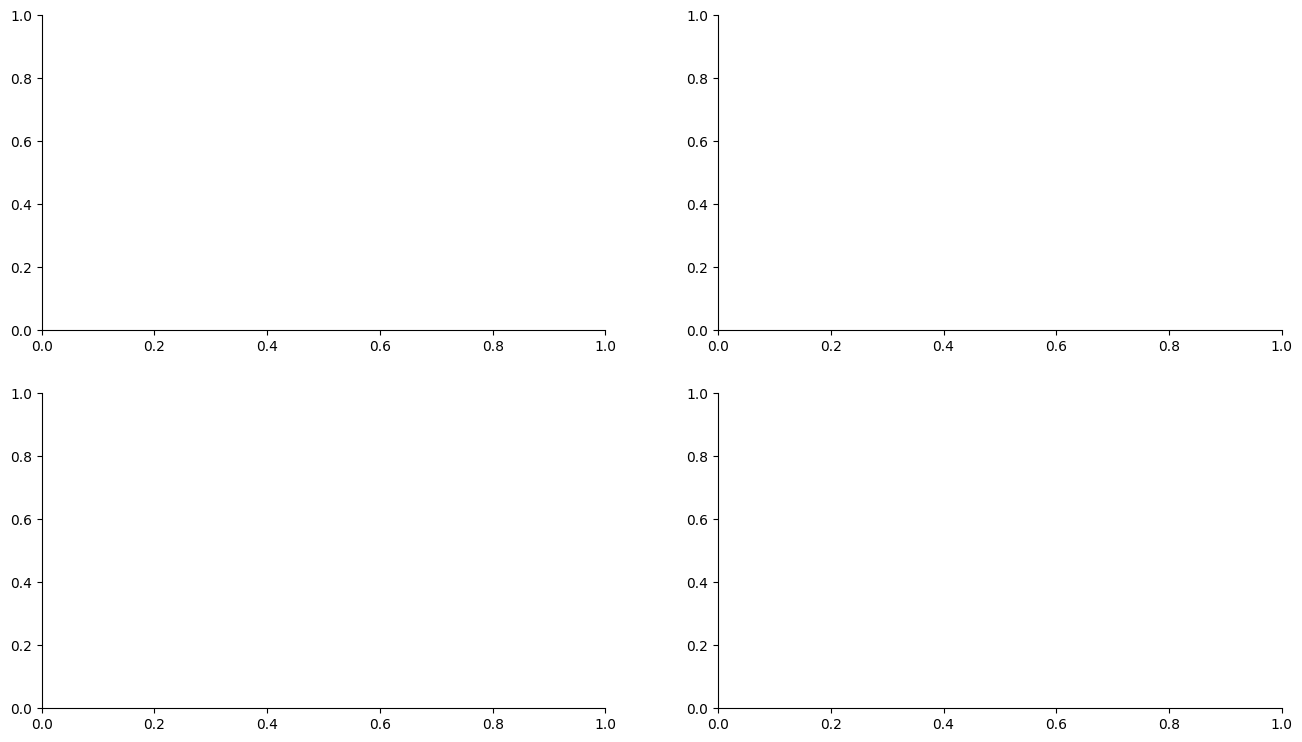

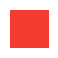

255 151 77


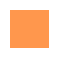

99 214 104


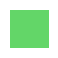

In [102]:
fig, axd = plt.subplot_mosaic(
    mosaic, gridspec_kw={"width_ratios": [1, 1], "wspace": 0.2}, figsize=(16, 9)
)
for color in df["color_29"].astype(str).unique():
    parts = " ".join(color.split()).split(" ")
    numbers = re.findall(r'\d+', color)
    print (numbers[0], numbers[1], numbers[2])
    r = int(numbers[0])
    g = int(numbers[1])
    b = int(numbers[2])
    fig, ax = plt.subplots(figsize=(0.5,0.5))
    ax.axis("off")
    ax.imshow([[(r, g, b)]])
    plt.show()

In [29]:
df[df["color_0"].astype(str) == "[253 226 147]"]

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,...,p31_green,p31_blue,color_32,p32_red,p32_green,p32_blue,color_33,p33_red,p33_green,p33_blue
13,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-123926.png,2023-10-17 12:39:26,"[253, 226, 147]",253,226,147,"[253, 226, 147]",253,...,214,104,"[99, 214, 104]",99,214,104,"[99, 214, 104]",99,214,104
29,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-124438.png,2023-10-17 12:44:38,"[253, 226, 147]",253,226,147,"[253, 226, 147]",253,...,214,104,"[99, 214, 104]",99,214,104,"[99, 214, 104]",99,214,104


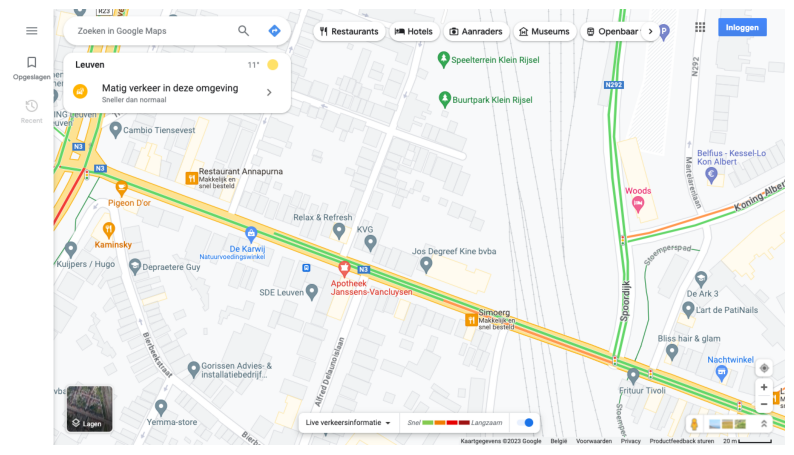

In [31]:
_ = display_shot("shots/leuven_tiensesteenweg_20231017-124438.png")

In [103]:
color_map = {
    "[129  31  31]": "darkred",
    "[242  60  50]": "red",
    "[255 151  77]": "orange",
    "[99 214 104]": "green"
 
}

In [104]:
for i in range(max_points):
    df[f"traffic_color_{i}"] = df[f"color_{i}"].astype(str).map(color_map)
df.sort_values(by="timestamp").head()

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,...,traffic_color_24,traffic_color_25,traffic_color_26,traffic_color_27,traffic_color_28,traffic_color_29,traffic_color_30,traffic_color_31,traffic_color_32,traffic_color_33
0,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,2023-10-17 15:57:34,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
1,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160247.png,2023-10-17 16:02:47,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160758.png,2023-10-17 16:07:58,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange
3,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-161310.png,2023-10-17 16:13:10,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange
4,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-161822.png,2023-10-17 16:18:22,"[129, 31, 31]",129,31,31,"[129, 31, 31]",129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
color_point = "color_20"
df[~df[color_point].astype(str).isin(color_map.keys())].groupby(df[color_point].astype(str)).size()

color_20
[ 99 214 104]    2
dtype: int64

In [106]:
wrong_color = "[243  80  71]"

In [47]:
for color in df[~df[color_point].astype(str).isin(color_map.keys())].groupby(df[color_point].astype(str)).size().index:
    if color=='None':
        continue
    print(f"{color=} {location=} {street=}")
    parts = " ".join(color.split()).split(" ")
    numbers = re.findall(r'\d+', color)
    print (numbers[0], numbers[1], numbers[2])
    r = int(numbers[0])
    g = int(numbers[1])
    b = int(numbers[2])
    plt.axis("off")
    plt.imshow([[(r, g, b)]])
    plt.show()

NameError: name 'color_point' is not defined

In [27]:
df[df[color_point].astype(str) == wrong_color]["path"].values[0]

PosixPath('shots/rotselaar_stationstraat_20230602-154321.png')

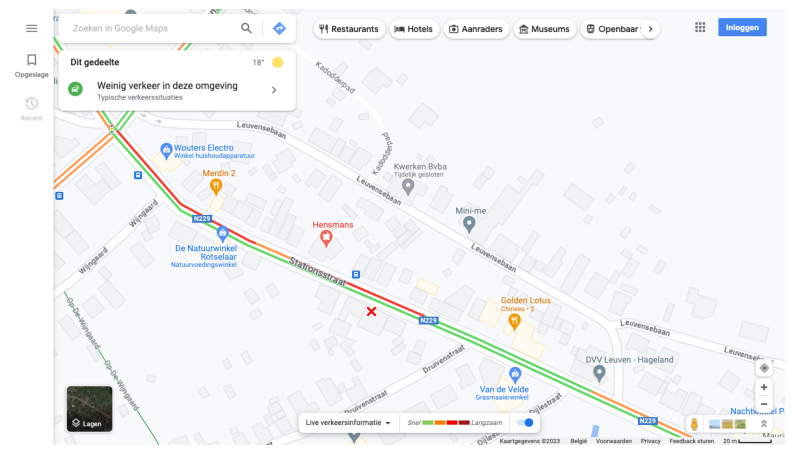

In [28]:
ax = display_shot(df[df[color_point].astype(str) == wrong_color]["path"].values[0])
point_coords = config[location]["rodenbachlaan"]["points"][6]
ax.scatter(point_coords[0], point_coords[1], marker="x", color="red");

In [29]:
df[df[color_point].astype(str) == wrong_color]["path"].values[0]

PosixPath('shots/rotselaar_stationstraat_20230602-154321.png')

In [48]:
def display_shot_region(url:  Union[str, os.PathLike], x:int, y:int, offset:int):
    if isinstance(url, str):
        image_url = Path(url)
    elif isinstance(url, os.PathLike):
        image_url = url
    else:
        raise TypeError("url must be a string or a path object")
    assert image_url.exists()
    im = cv2.cvtColor(cv2.imread(image_url.as_posix()), cv2.COLOR_BGR2RGB)
    # x, y, offset = point_coords[1], point_coords[0], 10
    xmin, xmax, ymin, ymax = x-offset, x+offset, y-offset, y+offset
    if xmax > im.shape[0]:
        xmax = im.shape[0]-1
    assert xmin >= 0
    assert xmax < im.shape[0]
    assert ymin >= 0
    assert ymax < im.shape[1]
    print (f"{xmin=}, {xmax=}, {ymin=}, {ymax=}")
    # xmin, xmax, ymin, ymax = 100, 110, 100, 110
    zoom = im[xmin:xmax, ymin:ymax, :]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_axis_off()
    ax.imshow(zoom);
    return ax

In [31]:
df[df[color_point].astype(str) == wrong_color]["path"].values[0]

PosixPath('shots/rotselaar_stationstraat_20230602-154321.png')

xmin=398, xmax=598, ymin=495, ymax=695


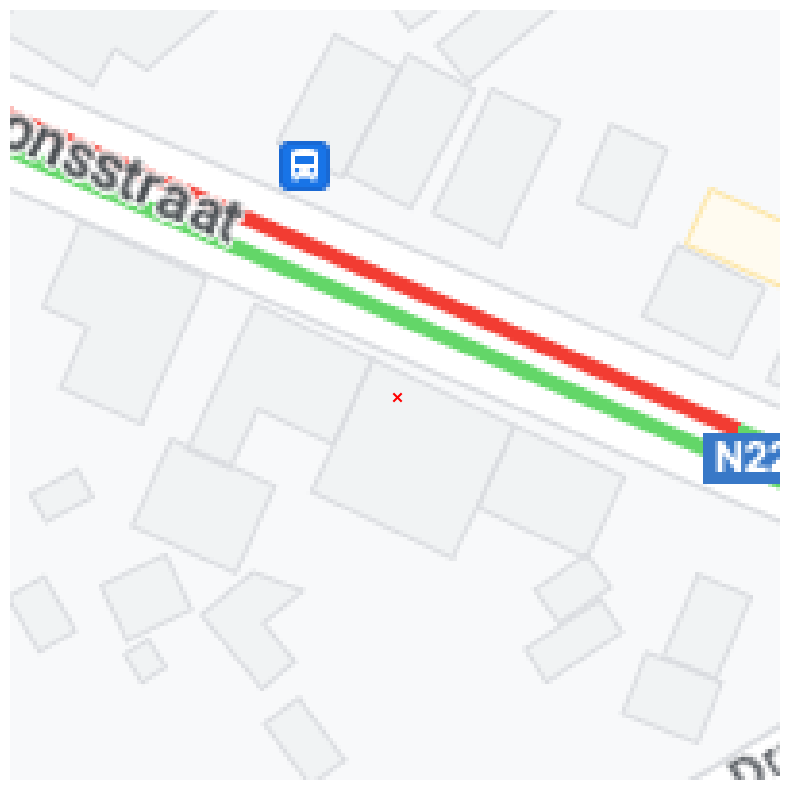

In [32]:
ax = display_shot_region(df[df[color_point].astype(str) == wrong_color]["path"].values[0], point_coords[1], point_coords[0], 100)
ax.scatter(100, 100, marker="x", color="red");

In [33]:
df[df[color_point].astype(str) == wrong_color][["street", "path"]]

,street,path
265,stationstraat,shots/rotselaar_stationstraat_20230602-154321.png


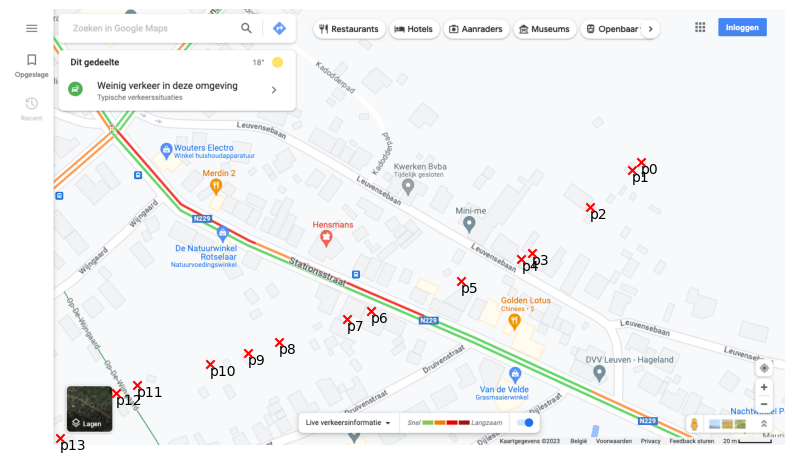

In [34]:
ax = display_shot(df[df[color_point].astype(str) == wrong_color]["path"].item())
for i, p in enumerate(config[location]["rodenbachlaan"]["points"]):
    ax.scatter(p[0], p[1], marker="x", color="red")
    ax.annotate(f"p{i}", (p[0], p[1]), horizontalalignment="left", verticalalignment="top")

In [35]:
point_coords

[595, 498]

In [107]:
df.filter(like='traffic_color', axis=1).isna().sum()

traffic_color_0      0
traffic_color_1      0
traffic_color_2      0
traffic_color_3      0
traffic_color_4      0
traffic_color_5      0
traffic_color_6      0
traffic_color_7      0
traffic_color_8      0
traffic_color_9      0
traffic_color_10     0
traffic_color_11     0
traffic_color_12     2
traffic_color_13     2
traffic_color_14     2
traffic_color_15     2
traffic_color_16     2
traffic_color_17     2
traffic_color_18     2
traffic_color_19     2
traffic_color_20     2
traffic_color_21    22
traffic_color_22    22
traffic_color_23    22
traffic_color_24    22
traffic_color_25    22
traffic_color_26    22
traffic_color_27    22
traffic_color_28    22
traffic_color_29     7
traffic_color_30    26
traffic_color_31     7
traffic_color_32     8
traffic_color_33     8
dtype: int64

# Analyse the data and make plot

In [116]:
df = df.sort_values(by="timestamp").reset_index(drop=True).copy()

In [162]:
df_resampled = df.set_index("timestamp").resample("1Min").ffill()

In [158]:
all_color_indexes = [f"matplotlib_color_{i}_index" for i in range(13)]
all_color_indexes

['matplotlib_color_0_index',
 'matplotlib_color_1_index',
 'matplotlib_color_2_index',
 'matplotlib_color_3_index',
 'matplotlib_color_4_index',
 'matplotlib_color_5_index',
 'matplotlib_color_6_index',
 'matplotlib_color_7_index',
 'matplotlib_color_8_index',
 'matplotlib_color_9_index',
 'matplotlib_color_10_index',
 'matplotlib_color_11_index',
 'matplotlib_color_12_index']

In [111]:
for color in color_map.keys():
    print (color)

[129  31  31]
[242  60  50]
[255 151  77]
[99 214 104]


In [112]:
color_space = [[0.50588235, 0.12156863, 0.12156863],
       [0.38823529, 0.83921569, 0.40784314],
       [1.        , 0.59215686, 0.30196078],
       [0.94901961, 0.23529412, 0.19607843],
       [1.        , 1.        , 1.        ]]

In [75]:
matplot_lib_map = {'darkred': 0, 'green': 1, 'orange': 2, 'red': 3, 'white': 4}

In [159]:
for i in range(34):
    df_resampled[f"matplotlib_color_{i}_index"] = df_resampled[f"traffic_color_{i}"].map(matplot_lib_map)

In [164]:
df_resampled

,location,street,path,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,p1_green,...,traffic_color_24,traffic_color_25,traffic_color_26,traffic_color_27,traffic_color_28,traffic_color_29,traffic_color_30,traffic_color_31,traffic_color_32,traffic_color_33
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-17 15:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-17 15:58:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 15:59:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:00:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:01:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17 18:03:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,"[242, 60, 50]",242.0,60.0,50.0,"[242, 60, 50]",242.0,60.0,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange
2023-10-17 18:04:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,"[242, 60, 50]",242.0,60.0,50.0,"[242, 60, 50]",242.0,60.0,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange
2023-10-17 18:05:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,"[242, 60, 50]",242.0,60.0,50.0,"[242, 60, 50]",242.0,60.0,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange


In [165]:
df_resampled = df_resampled.reset_index().iloc[3:].set_index("timestamp")
df_resampled.head()

,location,street,path,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,p1_green,...,traffic_color_24,traffic_color_25,traffic_color_26,traffic_color_27,traffic_color_28,traffic_color_29,traffic_color_30,traffic_color_31,traffic_color_32,traffic_color_33
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-17 16:00:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:01:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:02:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:03:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160247.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:04:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160247.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red


In [166]:
df_street = df_resampled.query("(street == 'tiensesteenweg')")
# df_street= df_street[df_street.index > "2023-06-02 15:30:00"]

In [167]:
df_street

,location,street,path,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,p1_green,...,traffic_color_24,traffic_color_25,traffic_color_26,traffic_color_27,traffic_color_28,traffic_color_29,traffic_color_30,traffic_color_31,traffic_color_32,traffic_color_33
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-17 16:00:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:01:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:02:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-155734.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:03:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160247.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
2023-10-17 16:04:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-160247.png,"[129, 31, 31]",129.0,31.0,31.0,"[129, 31, 31]",129.0,31.0,...,orange,orange,orange,orange,orange,red,NaN,red,red,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17 18:03:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,"[242, 60, 50]",242.0,60.0,50.0,"[242, 60, 50]",242.0,60.0,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange
2023-10-17 18:04:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,"[242, 60, 50]",242.0,60.0,50.0,"[242, 60, 50]",242.0,60.0,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange
2023-10-17 18:05:00,leuven,tiensesteenweg,shots/leuven_tiensesteenweg_20231017-180210.png,"[242, 60, 50]",242.0,60.0,50.0,"[242, 60, 50]",242.0,60.0,...,NaN,NaN,NaN,NaN,NaN,orange,NaN,orange,orange,orange


In [168]:
",".join(df_street.columns)

'location,street,path,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,p1_green,p1_blue,color_2,p2_red,p2_green,p2_blue,color_3,p3_red,p3_green,p3_blue,color_4,p4_red,p4_green,p4_blue,color_5,p5_red,p5_green,p5_blue,color_6,p6_red,p6_green,p6_blue,color_7,p7_red,p7_green,p7_blue,color_8,p8_red,p8_green,p8_blue,color_9,p9_red,p9_green,p9_blue,color_10,p10_red,p10_green,p10_blue,color_11,p11_red,p11_green,p11_blue,color_12,p12_red,p12_green,p12_blue,color_13,p13_red,p13_green,p13_blue,color_14,p14_red,p14_green,p14_blue,color_15,p15_red,p15_green,p15_blue,color_16,p16_red,p16_green,p16_blue,color_17,p17_red,p17_green,p17_blue,color_18,p18_red,p18_green,p18_blue,color_19,p19_red,p19_green,p19_blue,color_20,p20_red,p20_green,p20_blue,color_21,p21_red,p21_green,p21_blue,color_22,p22_red,p22_green,p22_blue,color_23,p23_red,p23_green,p23_blue,color_24,p24_red,p24_green,p24_blue,color_25,p25_red,p25_green,p25_blue,color_26,p26_red,p26_green,p26_blue,color_27,p27_red,p27_green,p27_blue,color_28,p

In [169]:
print_map = {"darkred":"*", "red":"x", "orange": "-"}

In [170]:
print_map.get(row[f'traffic_color_{0}'])

'x'

In [171]:
df_street["traffic_color_29"].unique()

array(['red', 'orange', nan], dtype=object)

In [251]:
for idx, row in df_street.iterrows():
    print(idx, end="")
    for i in range(34):
        symbol = print_map.get(row[f'traffic_color_{i}'], ".")
        print(symbol,  end="")
    print("\n")


2023-10-17 16:00:00************xxxxxxxxx--------x.xxx

2023-10-17 16:01:00************xxxxxxxxx--------x.xxx

2023-10-17 16:02:00************xxxxxxxxx--------x.xxx

2023-10-17 16:03:00************xxxxxxxxx--------x.xxx

2023-10-17 16:04:00************xxxxxxxxx--------x.xxx

2023-10-17 16:05:00************xxxxxxxxx--------x.xxx

2023-10-17 16:06:00************xxxxxxxxx--------x.xxx

2023-10-17 16:07:00************xxxxxxxxx--------x.xxx

2023-10-17 16:08:00************xxxxxxxxx........-.---

2023-10-17 16:09:00************xxxxxxxxx........-.---

2023-10-17 16:10:00************xxxxxxxxx........-.---

2023-10-17 16:11:00************xxxxxxxxx........-.---

2023-10-17 16:12:00************xxxxxxxxx........-.---

2023-10-17 16:13:00************xxxxxxxxx........-.---

2023-10-17 16:14:00************---------........-.---

2023-10-17 16:15:00************---------........-.---

2023-10-17 16:16:00************---------........-.---

2023-10-17 16:17:00************---------........-.---

2023-10-17

In [196]:
def print_colored_block(color_code, text):
   print(f"\033[{color_code}m{text}\033[0m", end="")

In [200]:
def print_colored_block(color_code, text):
   print(f"\u001b[{color_code}m{text}\x1b[0m", end="")

In [202]:
print_colored_block(90, "\u2588")

█

In [177]:
df_street["traffic_color_19"].unique()

array(['red', 'orange', nan], dtype=object)

In [175]:
ascii_color_map = {"darkred": 30,
                   "red": 31,
                   "orange": 32,
                   "green": 33}

In [252]:
for idx, row in df_street.iterrows():
    print("\n", idx, " ",end="")
    for i in range(34):
        ascii_color = ascii_color_map.get(row[f'traffic_color_{i}'], ".")
        print_colored_block(ascii_color, "\u2588")


 2023-10-17 16:00:00  ██████████████████████████████[.m████
 2023-10-17 16:01:00  ██████████████████████████████[.m████
 2023-10-17 16:02:00  ██████████████████████████████[.m████
 2023-10-17 16:03:00  ██████████████████████████████[.m████
 2023-10-17 16:04:00  ██████████████████████████████[.m████
 2023-10-17 16:05:00  ██████████████████████████████[.m████
 2023-10-17 16:06:00  ██████████████████████████████[.m████
 2023-10-17 16:07:00  ██████████████████████████████[.m████
 2023-10-17 16:08:00  █████████████████████[.m█[.m█[.m█[.m█[.m█[.m█[.m█[.m██[.m████
 2023-10-17 16:09:00  █████████████████████[.m█[.m█[.m█[.m█[.m█[.m█[.m█[.m██[.m████
 2023-10-17 16:10:00  █████████████████████[.m█[.m█[.m█[.m█[.m█[.m█[.m█[.m██[.m████
 2023-10-17 16:11:00  █████████████████████[.m█[.m█[.m█[.m█[.m█[.m█[.m█[.m██[.m████
 2023-10-17 16:12:00  █████████████████████[.m█[.m█[.m█[.m█[.m█[.m█[.m█[.m██[.m████
 2023-10-17 16:13:00  █████████████████████[.

# matplotlib

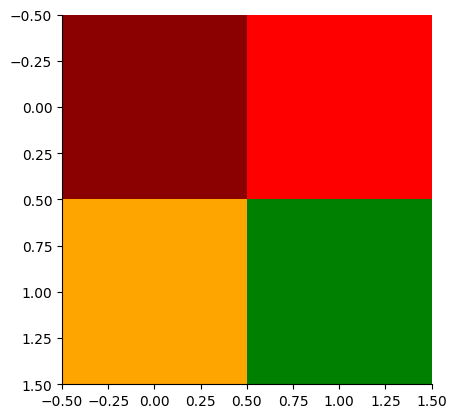

In [205]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["darkred", "red", "orange", "green"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

plt.imshow([[0, 1], [2,3]], cmap=cmap)
plt.show()

In [215]:
df_street.shape

(128, 205)

In [253]:
color_columns = [f"traffic_color_{i}" for i in range(34)]
color2index ={"darkred":0, "red":1, "orange":2, "green":3}
index_columns= []
for idx, colom in enumerate(color_columns):
    df_street[f"index_color_{idx}"] = df_street[colom].map(color2index)
    index_columns.append(f"index_color_{idx}")
traffic_color_matrix = df_street[index_columns].fillna(3).to_numpy()
traffic_color_matrix

/var/folders/l3/cl401yld1x3f35c0g3sbm3b80000gp/T/ipykernel_93407/407041901.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_street[f"index_color_{idx}"] = df_street[colom].map(color2index)
/var/folders/l3/cl401yld1x3f35c0g3sbm3b80000gp/T/ipykernel_93407/407041901.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_street[f"index_color_{idx}"] = df_street[colom].map(color2index)


array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.],
       [1., 1., 1., ..., 2., 2., 2.]])

In [273]:
from matplotlib.text import Text

/var/folders/l3/cl401yld1x3f35c0g3sbm3b80000gp/T/ipykernel_93407/4256181284.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels);


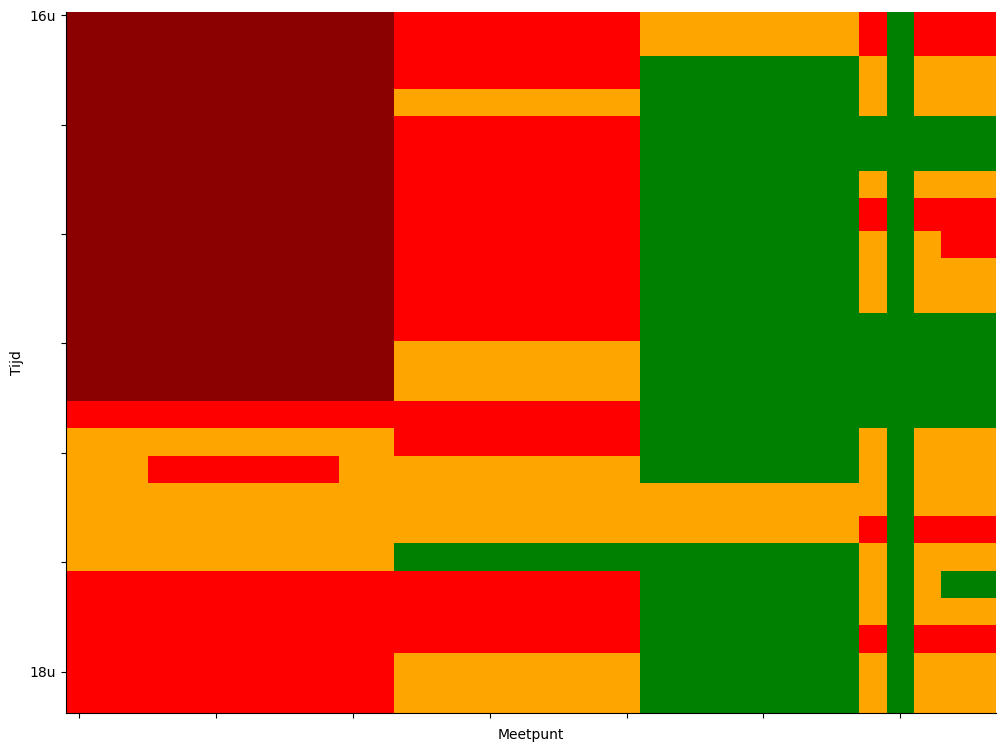

In [286]:
fig, ax = plt.subplots(figsize=(12, 12))
# plt.figure().set_figheight(1)
# plt.figure().set_figwidth(10)
plt.imshow(traffic_color_matrix, cmap=cmap, aspect=0.2);
# plt.axis('off');
ax.set_xlabel("Meetpunt")
ax.set_ylabel("Tijd");
# ax.set_xticks([]);
# ax.set_yticks([]);
ylabels = ax.get_yticklabels()
for idx, label in enumerate(ylabels):
    ylabels[idx].set_text('')
    if idx == 1:
        ylabels[1].set_text('16u')
    if idx == len(ylabels)-2:
        ylabels[-2].set_text('18u')
# xlabels[0] = Text(0.0, 0, '16u')
# xlabels[-1] = Text(35.0, 0, '18u')
ax.set_xticklabels([]);
ax.set_yticklabels(ylabels);


In [281]:
ylabels

[Text(0, -20.0, '16u'),
 Text(0, 0.0, '0'),
 Text(0, 20.0, '20'),
 Text(0, 40.0, '40'),
 Text(0, 60.0, '60'),
 Text(0, 80.0, '80'),
 Text(0, 100.0, '100'),
 Text(0, 120.0, '120'),
 Text(0, 140.0, '18u')]

In [ ]:
len(index_columns)

In [219]:
df_street.shape[0]

128

In [220]:
resized_traffic_color_matrix = np.resize(traffic_color_matrix, ( 10*df_street.shape[0], 10*len(index_columns),))

In [222]:
resized_traffic_color_matrix[:20, :20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2.,
        2., 2., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2.,
        2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2.

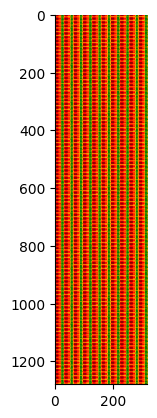

In [221]:
plt.imshow(resized_traffic_color_matrix, cmap=cmap);

In [80]:
df_resampled[all_color_indexes].T.values

array([[nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  2.,  3.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  2.,  3.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  3.,  2.,  3.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.],
       [nan,  0.,  0.,  0.,  0.,  0.,  0

In [81]:
df_street.shape

(26, 207)

NameError: name 'labels' is not defined

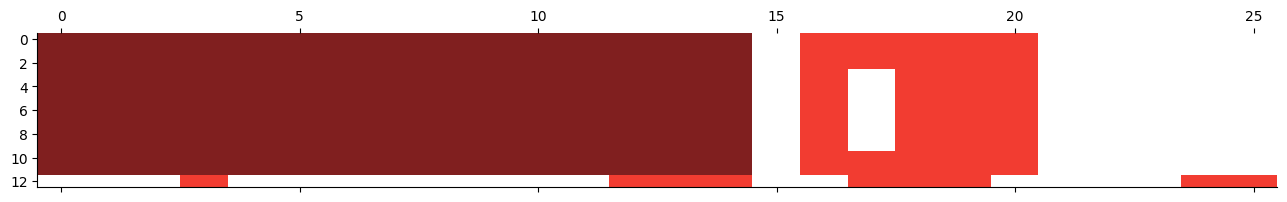

In [82]:
from matplotlib import colors
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

traffic_colorspace = colors.ListedColormap(color_space)

fig, ax = plt.subplots(figsize = (16,2))
ax.matshow(df_street[all_color_indexes].T.values, cmap=traffic_colorspace, aspect="auto");
# ax.xaxis.set_major_locator(ticker.FixedLocator([t for t in range(77)]))
# labels = df_street.index.strftime("%d\n%H").values.copy()

sparse_labels = [labels[0]]
for l1, l2 in zip(labels[:-1], labels[1:]):
    label = f"Mei {l2}" if l1[:2] != l2[:2] else l2[3:]
    sparse_labels.append(label)
sparse_labels[0] = "June 6\n15"
# sparse_labels.append(int(sparse_labels[-1])+1)
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(sparse_labels))
ax.grid(axis = "y")
ax.set_axisbelow(False)

In [ ]:
df_resampled.tail()

,location,street,path,color_0,p0_red,p0_green,p0_blue,color_1,p1_red,p1_green,...,matplotlib_color_32_index,matplotlib_color_33_index,matplotlib_color_34_index,matplotlib_color_35_index,matplotlib_color_36_index,matplotlib_color_37_index,matplotlib_color_38_index,matplotlib_color_39_index,matplotlib_color_40_index,matplotlib_color_41_index
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-02 21:50:00,rotselaar,provinciebaan,shots/rotselaar_provinciebaan_20230602-214625.png,"[255, 255, 255]",255.0,255.0,255.0,"[255, 255, 255]",255.0,255.0,...,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-02 21:55:00,rotselaar,provinciebaan,shots/rotselaar_provinciebaan_20230602-215136.png,"[255, 255, 255]",255.0,255.0,255.0,"[255, 255, 255]",255.0,255.0,...,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-02 22:00:00,rotselaar,provinciebaan,shots/rotselaar_provinciebaan_20230602-215646.png,"[255, 255, 255]",255.0,255.0,255.0,"[255, 255, 255]",255.0,255.0,...,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-02 22:05:00,rotselaar,provinciebaan,shots/rotselaar_provinciebaan_20230602-220157.png,"[255, 255, 255]",255.0,255.0,255.0,"[255, 255, 255]",255.0,255.0,...,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-02 22:10:00,rotselaar,provinciebaan,shots/rotselaar_provinciebaan_20230602-220708.png,"[255, 255, 255]",255.0,255.0,255.0,"[255, 255, 255]",255.0,255.0,...,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN


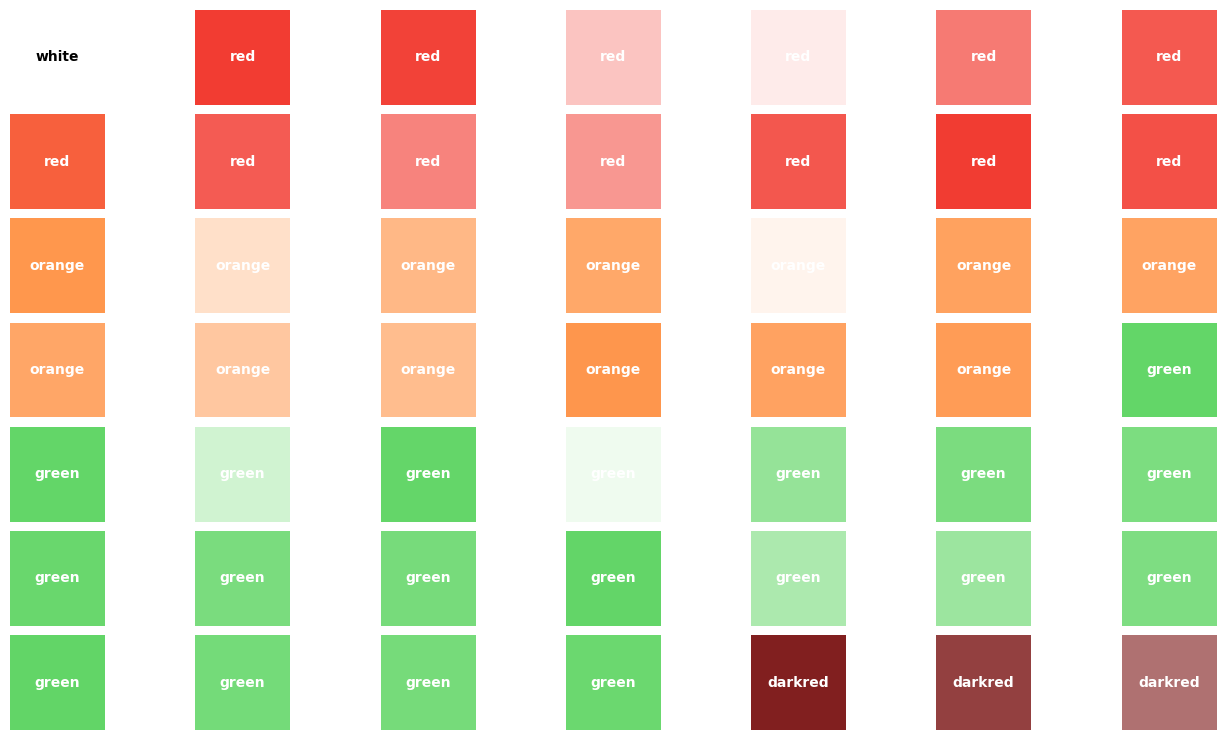

In [99]:
n_colors = len(color_map)
n_cols = int(np.round(np.sqrt(n_colors), 0))
n_rows = n_colors//n_cols
# fig, axd = plt.subplot_mosaic(
#     mosaic, gridspec_kw={"width_ratios": [1,]*n_cols, "wspace": 1/n_cols}, figsize=(16, 9)
# )
fig, axes = plt.subplots(n_cols, n_rows, figsize=(16,9))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
for ax, (color, color_name) in zip(axes.flat, color_map.items()):
    parts = " ".join(color.split()).split(" ")
    numbers = re.findall(r'\d+', color)
    # print (numbers[0], numbers[1], numbers[2], color_name)
    r = int(numbers[0])
    g = int(numbers[1])
    b = int(numbers[2])
    # fig, ax = plt.subplots(figsize=(0.5,0.5))

    ax.axis("off")
    ax.imshow([[(r, g, b)]])
    color = "k" if color_name == "white" else "white"
    ax.text(
        s=color_name,
        x=0,
        y=0,
        ha='center',
        va='center',
        color=color,
        fontdict={"fontweight":"bold"}
        # path_effects=[
        #     Stroke(foreground='black', linewidth=1), Normal()
        # ]
    )
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()


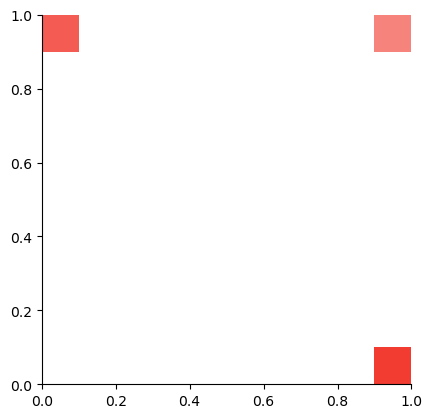

In [85]:
from matplotlib.patches import Rectangle

w = h = 0.2
row, col = 0, 0
fig, ax = plt.subplots()
for color, color_name in color_map.items():
    parts = " ".join(color.split()).split(" ")
    numbers = re.findall(r'\d+', color)
    # print (numbers[0], numbers[1], numbers[2])
    r = int(numbers[0])
    g = int(numbers[1])
    b = int(numbers[2])
    mpl_color = np.array([r/255, g/255, b/255])
    p = Rectangle((col-h/2, row-w/2), w, h, fc=mpl_color)
    ax.add_artist(p)
    col += 1
    if col > n_cols:
        row += 1
        col = 0
ax.set_aspect("equal")

In [83]:
n_cols

7